# Sentiment Analysis with BERT

In [1]:
!pip install datasets huggingface_hub transformers

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
!kaggle datasets download -d prakharrathi25/google-play-store-reviews

Dataset URL: https://www.kaggle.com/datasets/prakharrathi25/google-play-store-reviews
License(s): CC0-1.0
  0% 0.00/2.55M [00:00<?, ?B/s]
100% 2.55M/2.55M [00:00<00:00, 63.1MB/s]


In [5]:
!unzip /content/google-play-store-reviews.zip

Archive:  /content/google-play-store-reviews.zip
  inflating: reviews.csv             


In [6]:
df = pd.read_csv("reviews.csv")
df.shape

(12495, 12)

In [7]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...,Eric Tie,https://play-lh.googleusercontent.com/a-/AOh14...,I cannot open the app anymore,1,0,5.4.0.6,2020-10-27 21:24:41,NaN,NaN,newest,com.anydo
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...,john alpha,https://play-lh.googleusercontent.com/a-/AOh14...,I have been begging for a refund from this app...,1,0,NaN,2020-10-27 14:03:28,"Please note that from checking our records, yo...",2020-10-27 15:05:52,newest,com.anydo
2,gp:AOqpTOEMCkJB8Iq1p-r9dPwnSYadA5BkPWTf32Z1azu...,Sudhakar .S,https://play-lh.googleusercontent.com/a-/AOh14...,Very costly for the premium version (approx In...,1,0,NaN,2020-10-27 08:18:40,NaN,NaN,newest,com.anydo
3,gp:AOqpTOGFrUWuKGycpje8kszj3uwHN6tU_fd4gLVFy9z...,SKGflorida@bellsouth.net DAVID S,https://play-lh.googleusercontent.com/-75aK0WF...,"Used to keep me organized, but all the 2020 UP...",1,0,NaN,2020-10-26 13:28:07,What do you find troublesome about the update?...,2020-10-26 14:58:29,newest,com.anydo
4,gp:AOqpTOHls7DW8wmDFzTkHwxuqFkdNQtKHmO6Pt9jhZE...,Louann Stoker,https://play-lh.googleusercontent.com/-pBcY_Z-...,Dan Birthday Oct 28,1,0,5.6.0.7,2020-10-26 06:10:50,NaN,NaN,newest,com.anydo


In [8]:
df.isnull().sum()

reviewId                   0
userName                   0
userImage                  0
content                    0
score                      0
thumbsUpCount              0
reviewCreatedVersion    2162
at                         0
replyContent            6677
repliedAt               6677
sortOrder                  0
appId                      0
dtype: int64

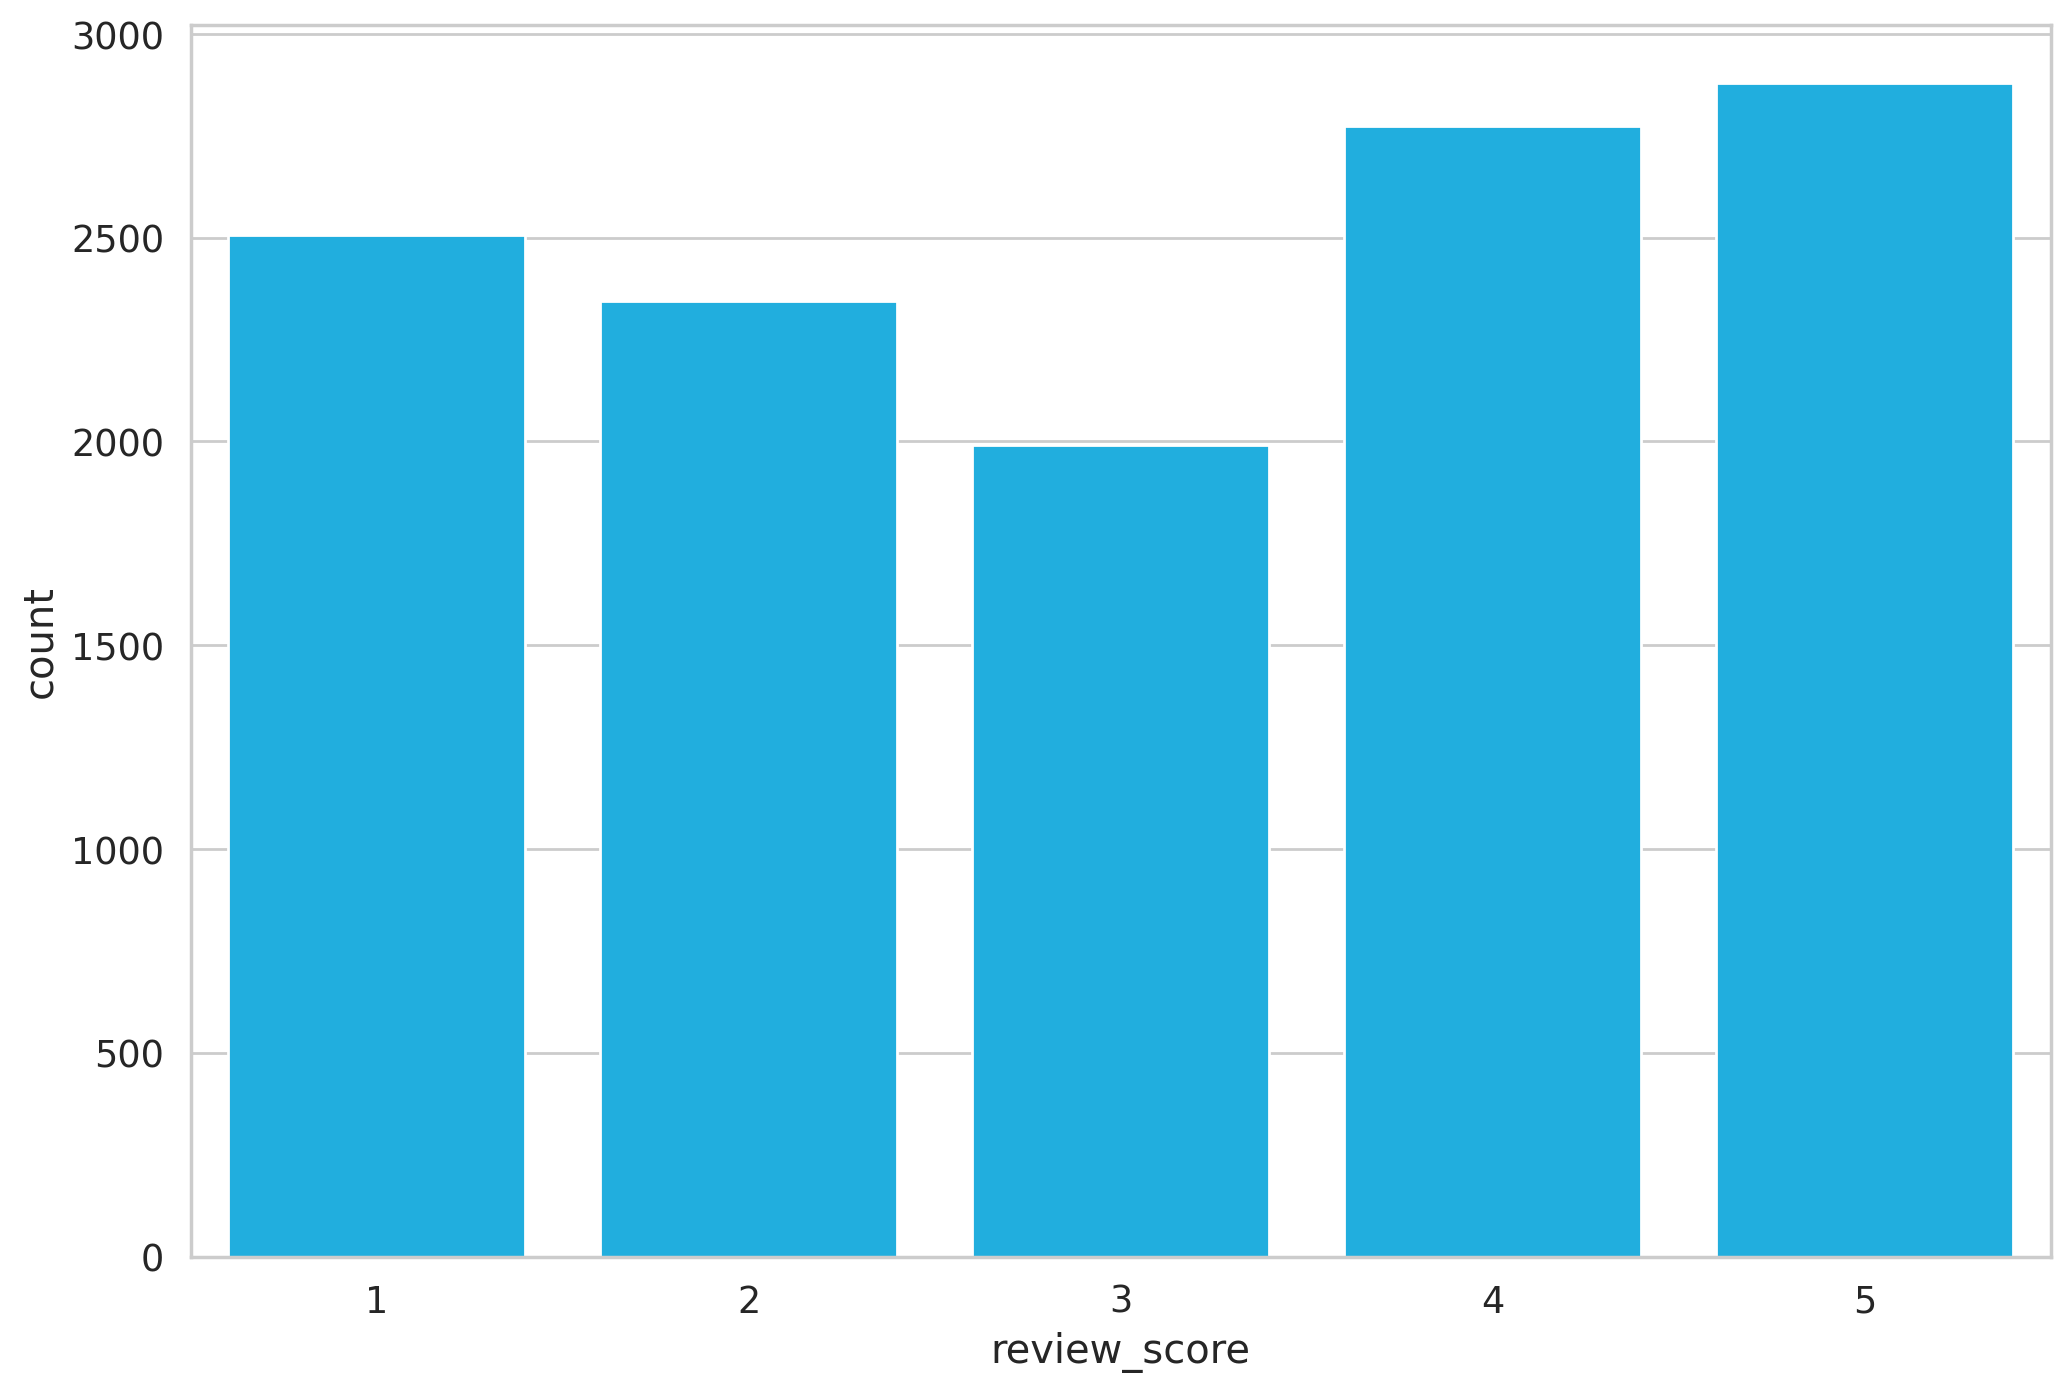

In [9]:
# convert scores to three classes
sns.countplot(data=df, x="score")
plt.xlabel("review_score")
plt.show()

[Text(0, 0, 'negative'), Text(1, 0, 'neutral'), Text(2, 0, 'positive')]

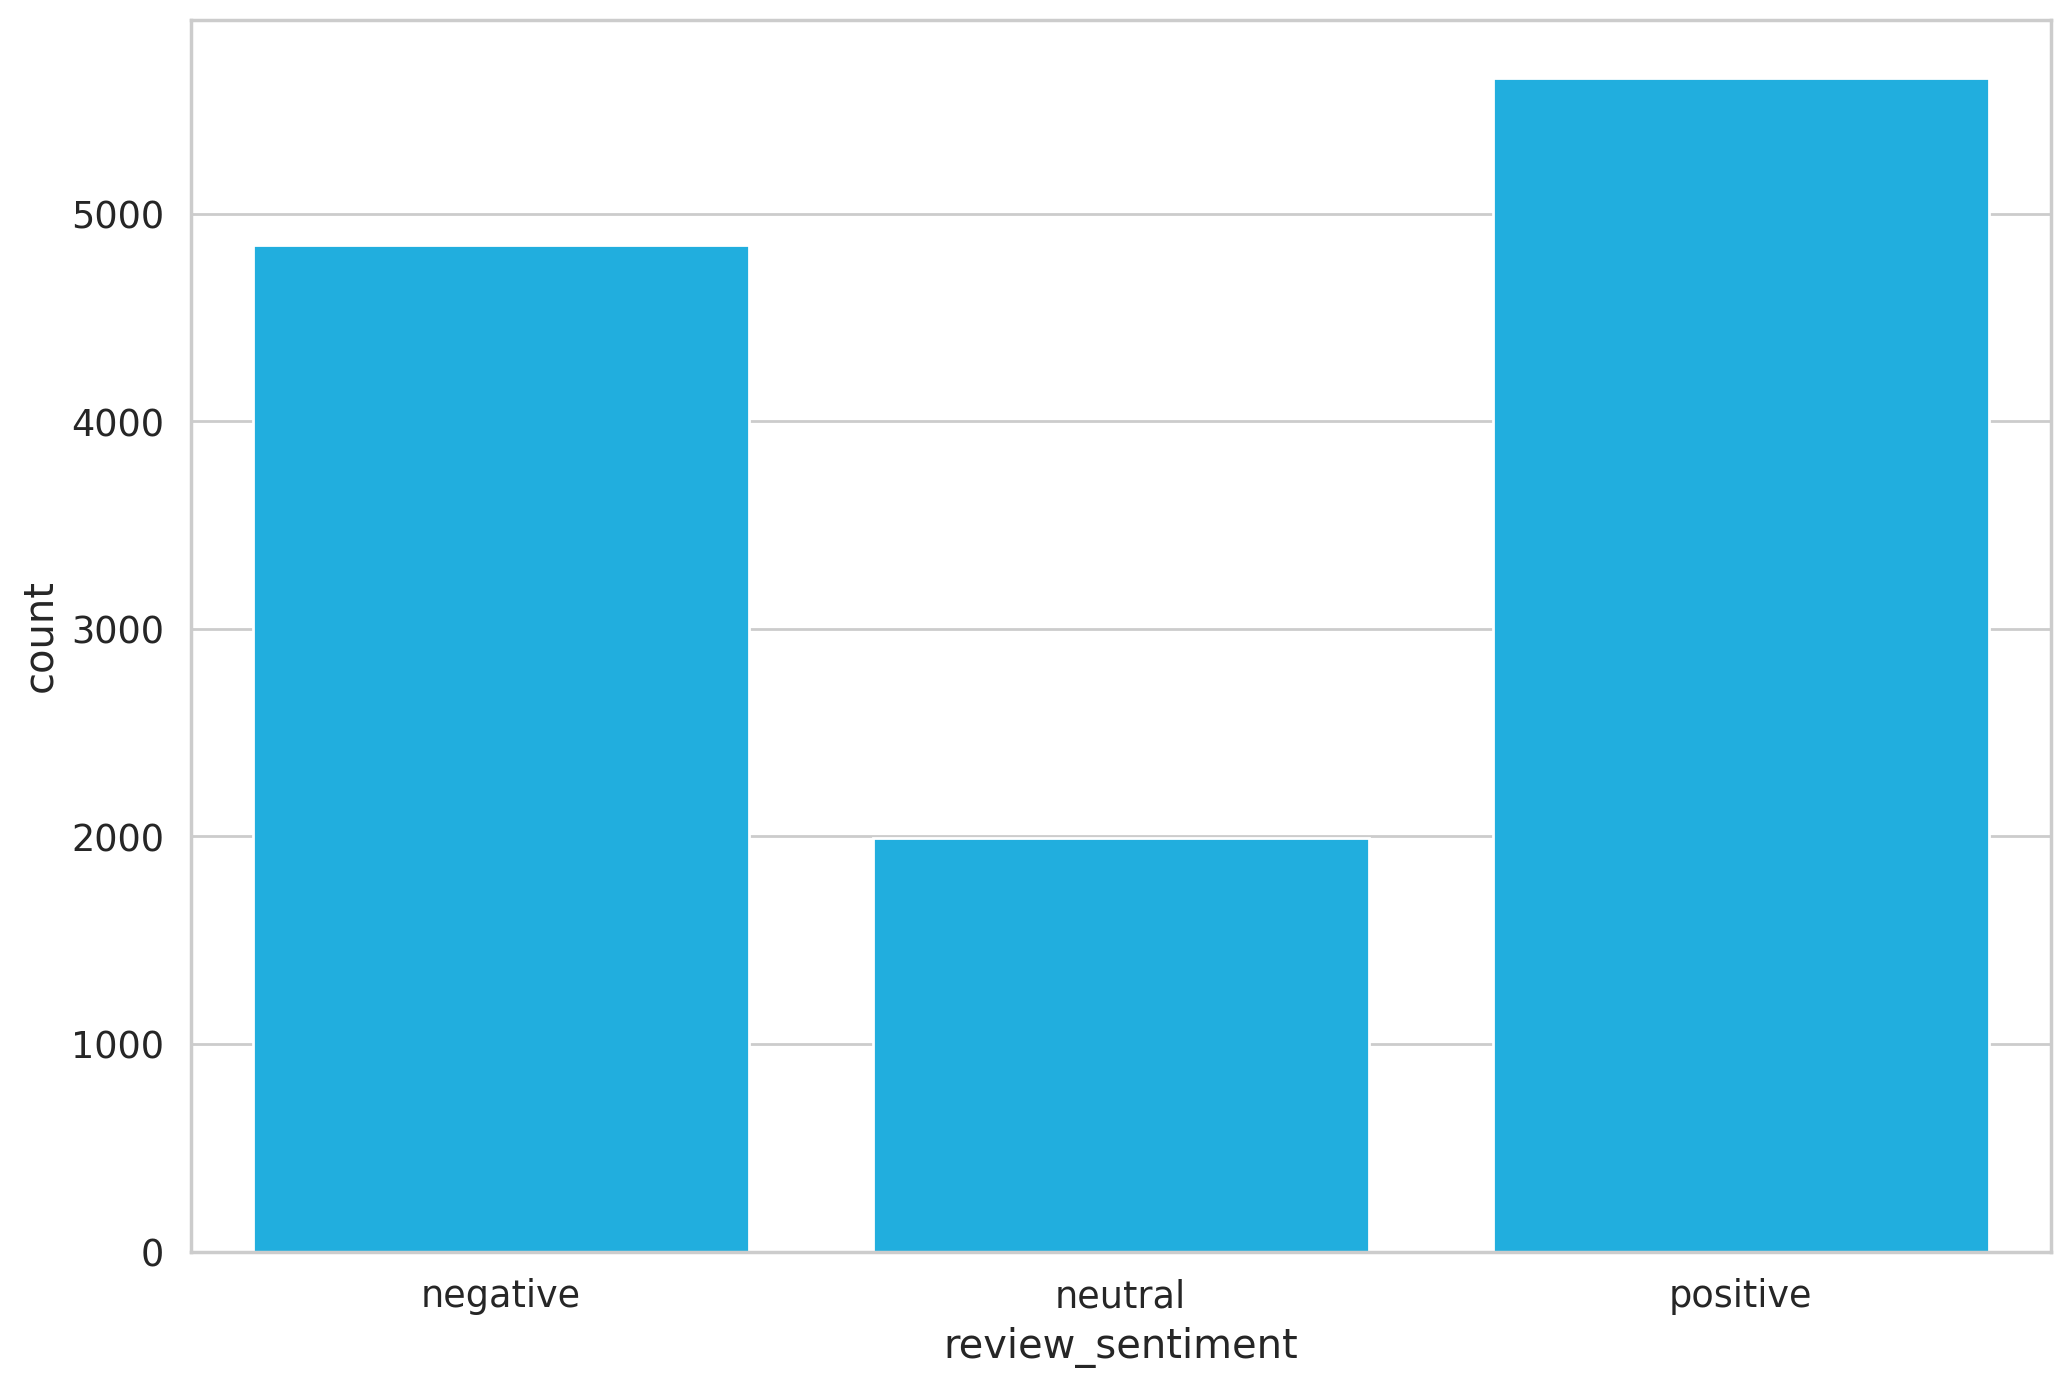

In [10]:
df['sentiment'] = df.score.apply(lambda x: 0 if x <= 2 else (1 if x == 3 else 2))
class_names = ["negative", "neutral", "positive"]
ax = sns.countplot(data=df, x="sentiment")
plt.xlabel("review_sentiment")
ax.set_xticklabels(class_names)

In [11]:
MODEL_NAME = "bert-base-cased"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [12]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [13]:
token_lens = []

for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Text(0.5, 0, 'Token count')

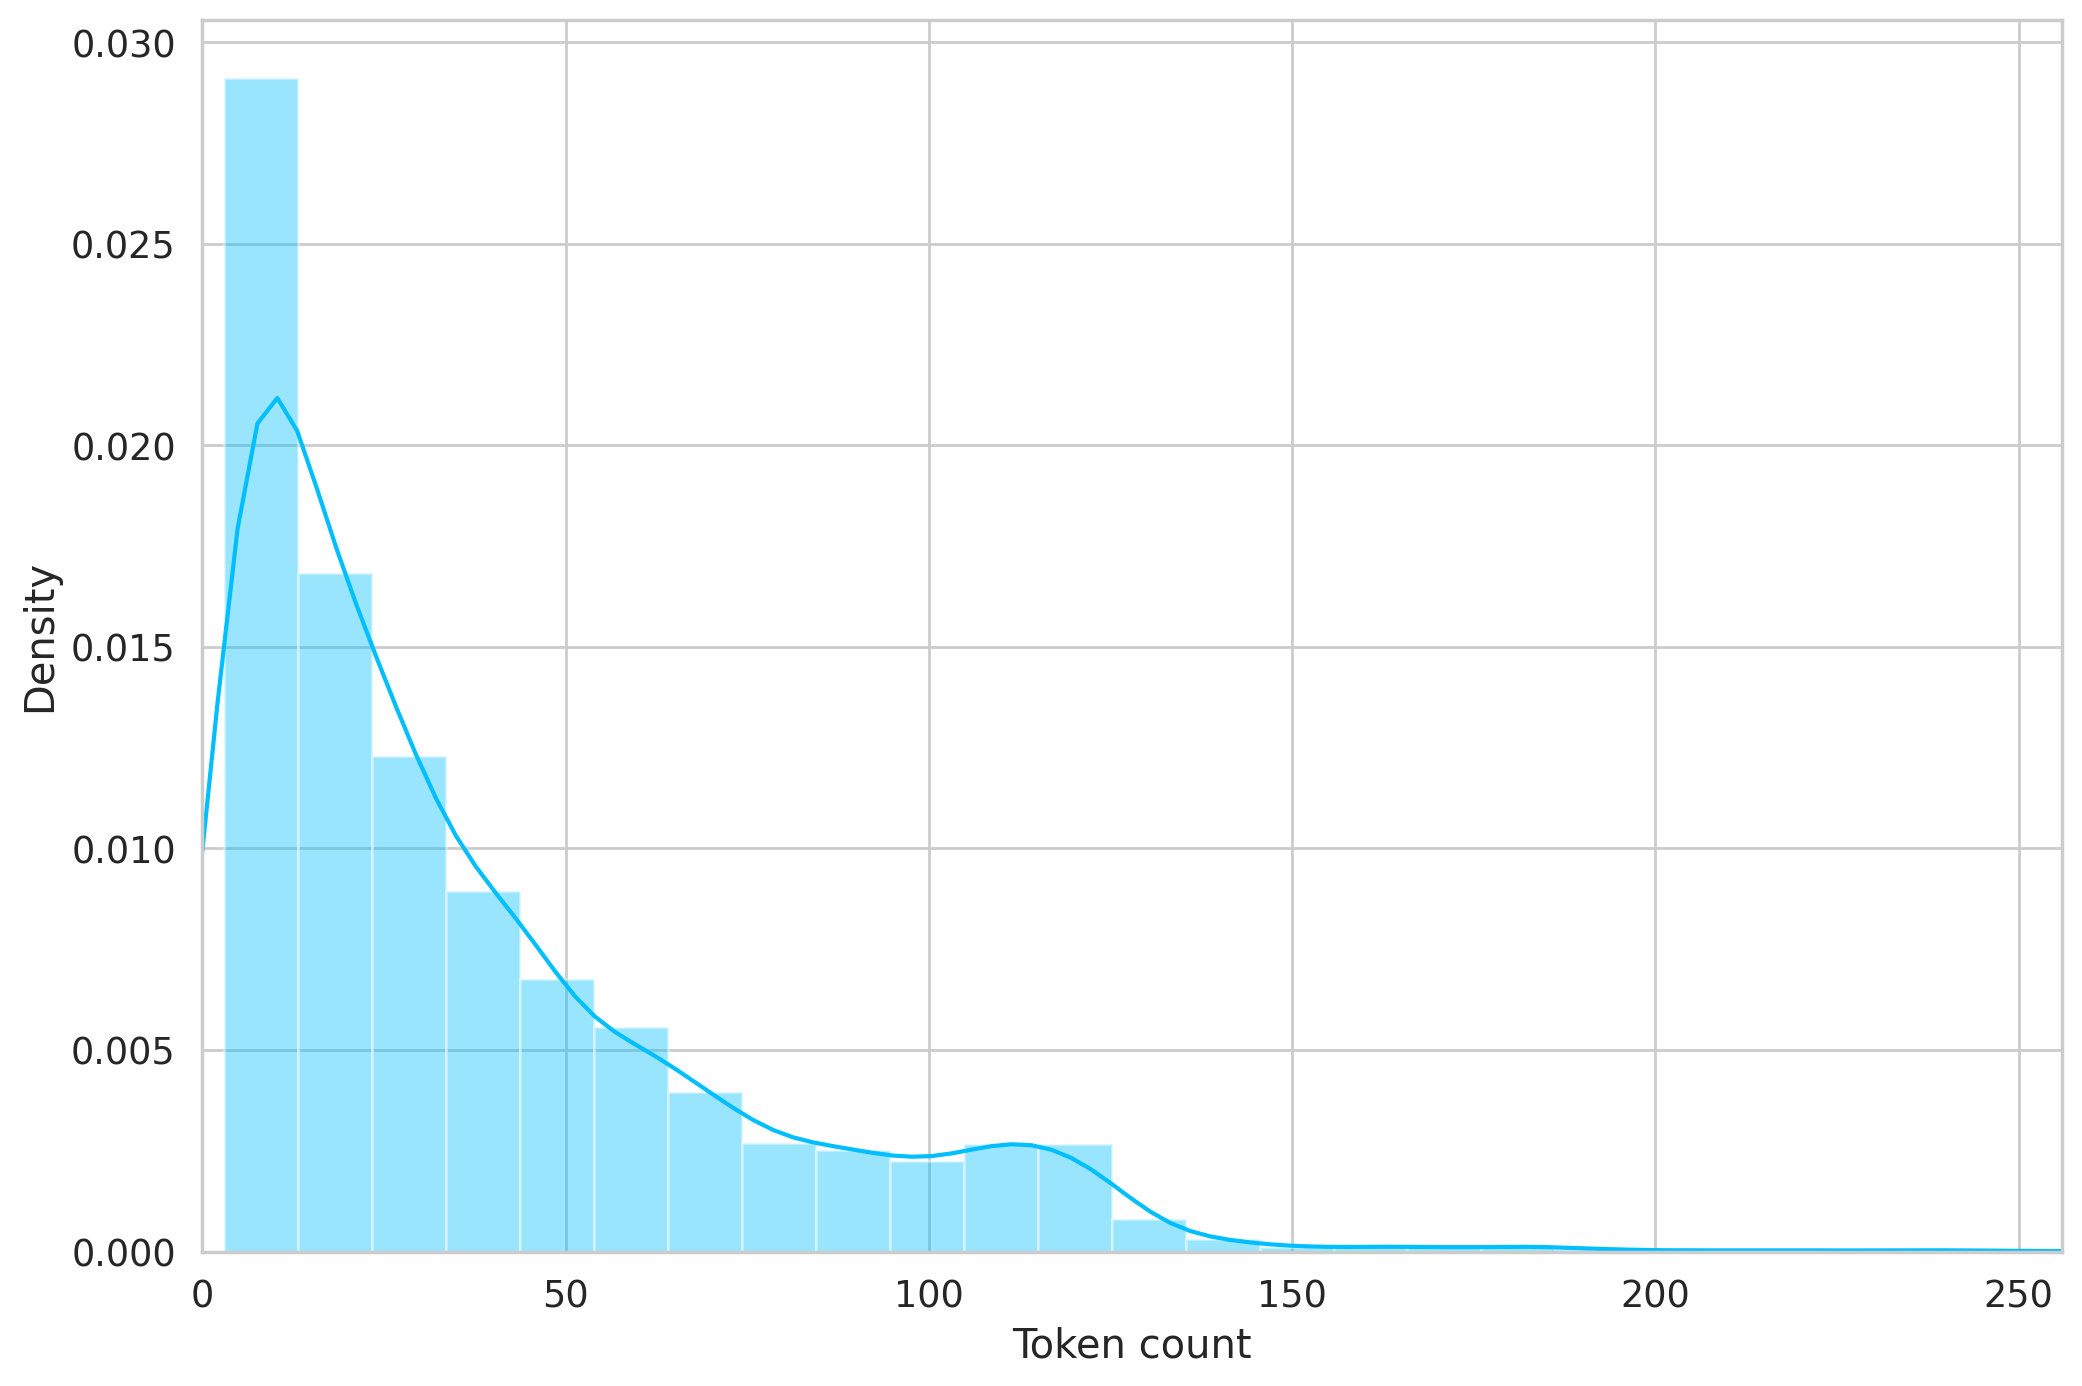

In [14]:
sns.distplot(token_lens)
plt.xlim([0, 256])
plt.xlabel("Token count")

In [15]:
MAX_LEN = 160

# Data Generator Class
class GPReviewDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors="pt",
    )

    return {
        "review_text" : review,
        "input_ids" : encoding["input_ids"].flatten(),
        "attention_mask" : encoding["attention_mask"].flatten(),
        "targets" : torch.tensor(target, dtype=torch.long)
    }

# train-test-val set
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print("Training set shape: {}\nTest set shape: {}\nValidation set shape: {}".format(df_train.shape, df_test.shape, df_val.shape))

Training set shape: (9996, 13)
Test set shape: (1250, 13)
Validation set shape: (1249, 13)


In [16]:
# Create Dataloader
def create_dataloader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
      reviews=df.content.to_numpy(),
      targets=df.sentiment.to_numpy(),
      tokenizer=tokenizer,
      max_len=max_len
  )

  return DataLoader(
      ds,
      batch_size=batch_size,
      num_workers=0
  )

BATCH_SIZE = 16
train_data_loader = create_dataloader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_dataloader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_dataloader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [17]:
data = next(iter(train_data_loader))
print(data.keys())

print("Input shape: {}\nAttention mask: {}\nTarget shape: {}".format(data['input_ids'].shape, data['attention_mask'].shape, data['targets'].shape))

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
Input shape: torch.Size([16, 160])
Attention mask: torch.Size([16, 160])
Target shape: torch.Size([16])


In [18]:
bert_model = BertModel.from_pretrained(MODEL_NAME)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [19]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    # self.optimizer = optim.Adam(self.parameters(), lr=23-5, correct_bias=False)

  def forward(self, input_ids=None, attention_mask=None):
    _, pooled_output = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask,
        return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [20]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [21]:
print(bert_model.config.hidden_size)

768


In [22]:
# Number of iterations
EPOCHS = 10

optimizer = optim.Adam(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS

# using scheduler without warmup so there is no ramp up with a smaller learning rate
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [23]:
# training
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    # Backward prop
    loss.backward()

    # Gradient Descent
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

# evaluation
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      # Get model ouptuts
      outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
      )

      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [24]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
  print(f"Epoch {epoch + 1} / {EPOCHS}")
  print("-" * 10)

  train_acc, train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(df_train)
  )

  print(f"Train loss {train_loss} accuracy {train_acc}")

  val_acc, val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn,
      device,
      len(df_val)
  )
  print(f"Val loss: {val_loss}, Val Accuracy: {val_acc}")
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), "best_model_state.bin")
    best_accuracy = val_acc

Epoch 1 / 10
----------
Train loss 0.699131705212593 accuracy 0.723889555822329
Val loss: 0.5812018274129191, Val Accuracy: 0.7654123298638911

Epoch 2 / 10
----------
Train loss 0.5256863366007805 accuracy 0.7966186474589837
Val loss: 0.636713134902942, Val Accuracy: 0.7526020816653323

Epoch 3 / 10
----------
Train loss 0.40205626133680344 accuracy 0.8528411364545819
Val loss: 0.6746683122613762, Val Accuracy: 0.7510008006405123

Epoch 4 / 10
----------
Train loss 0.2900443443655968 accuracy 0.8987595038015207
Val loss: 0.880479584389095, Val Accuracy: 0.7526020816653323

Epoch 5 / 10
----------
Train loss 0.2220984562769532 accuracy 0.9287715086034415
Val loss: 1.0830783810042128, Val Accuracy: 0.7453963170536428

Epoch 6 / 10
----------
Train loss 0.16750210606548935 accuracy 0.9519807923169268
Val loss: 1.2030383842655374, Val Accuracy: 0.7582065652522018

Epoch 7 / 10
----------
Train loss 0.12395878660716117 accuracy 0.9679871948779513
Val loss: 1.3952770776386503, Val Accuracy:

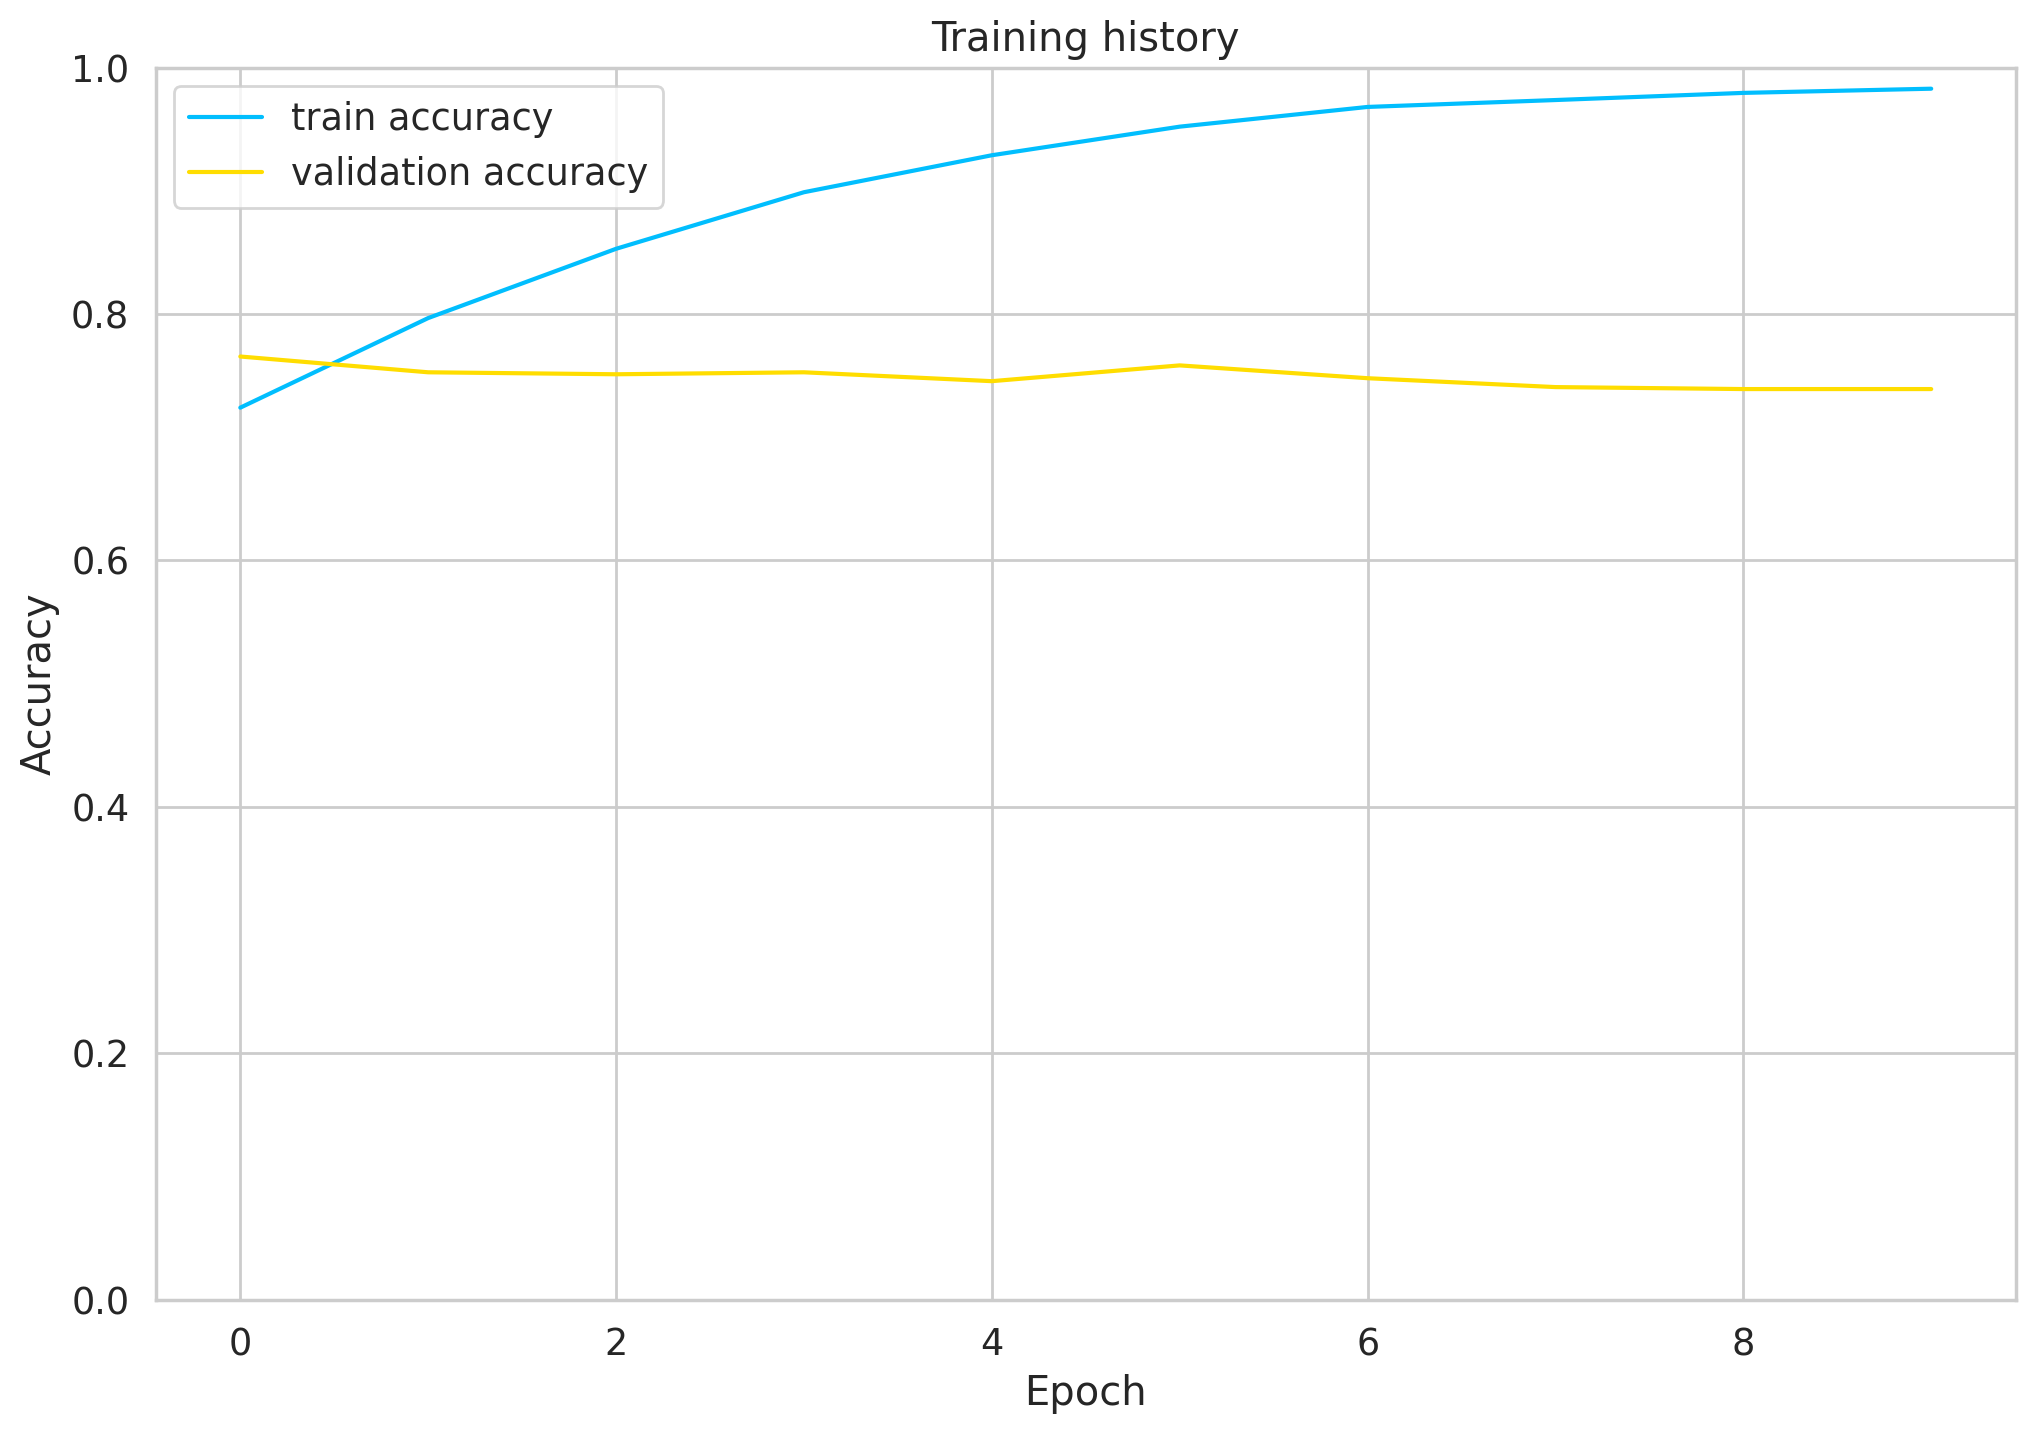

In [25]:
def move_to_cpu(data):
    if isinstance(data, torch.Tensor):
        return data.cpu().numpy()
    elif isinstance(data, list):
        return [move_to_cpu(item) for item in data]
    else:
        return data
history_cpu = {k: move_to_cpu(v) for k, v in history.items()}

# Plot training and validation accuracy
plt.plot(history_cpu['train_acc'], label='train accuracy')
plt.plot(history_cpu['val_acc'], label='validation accuracy')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [26]:
test_acc, _ = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(df_test)
)
test_acc.item()

0.736

In [27]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values


In [28]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.77      0.79      0.78       480
     neutral       0.39      0.37      0.38       216
    positive       0.84      0.83      0.84       554

    accuracy                           0.74      1250
   macro avg       0.66      0.66      0.66      1250
weighted avg       0.73      0.74      0.73      1250



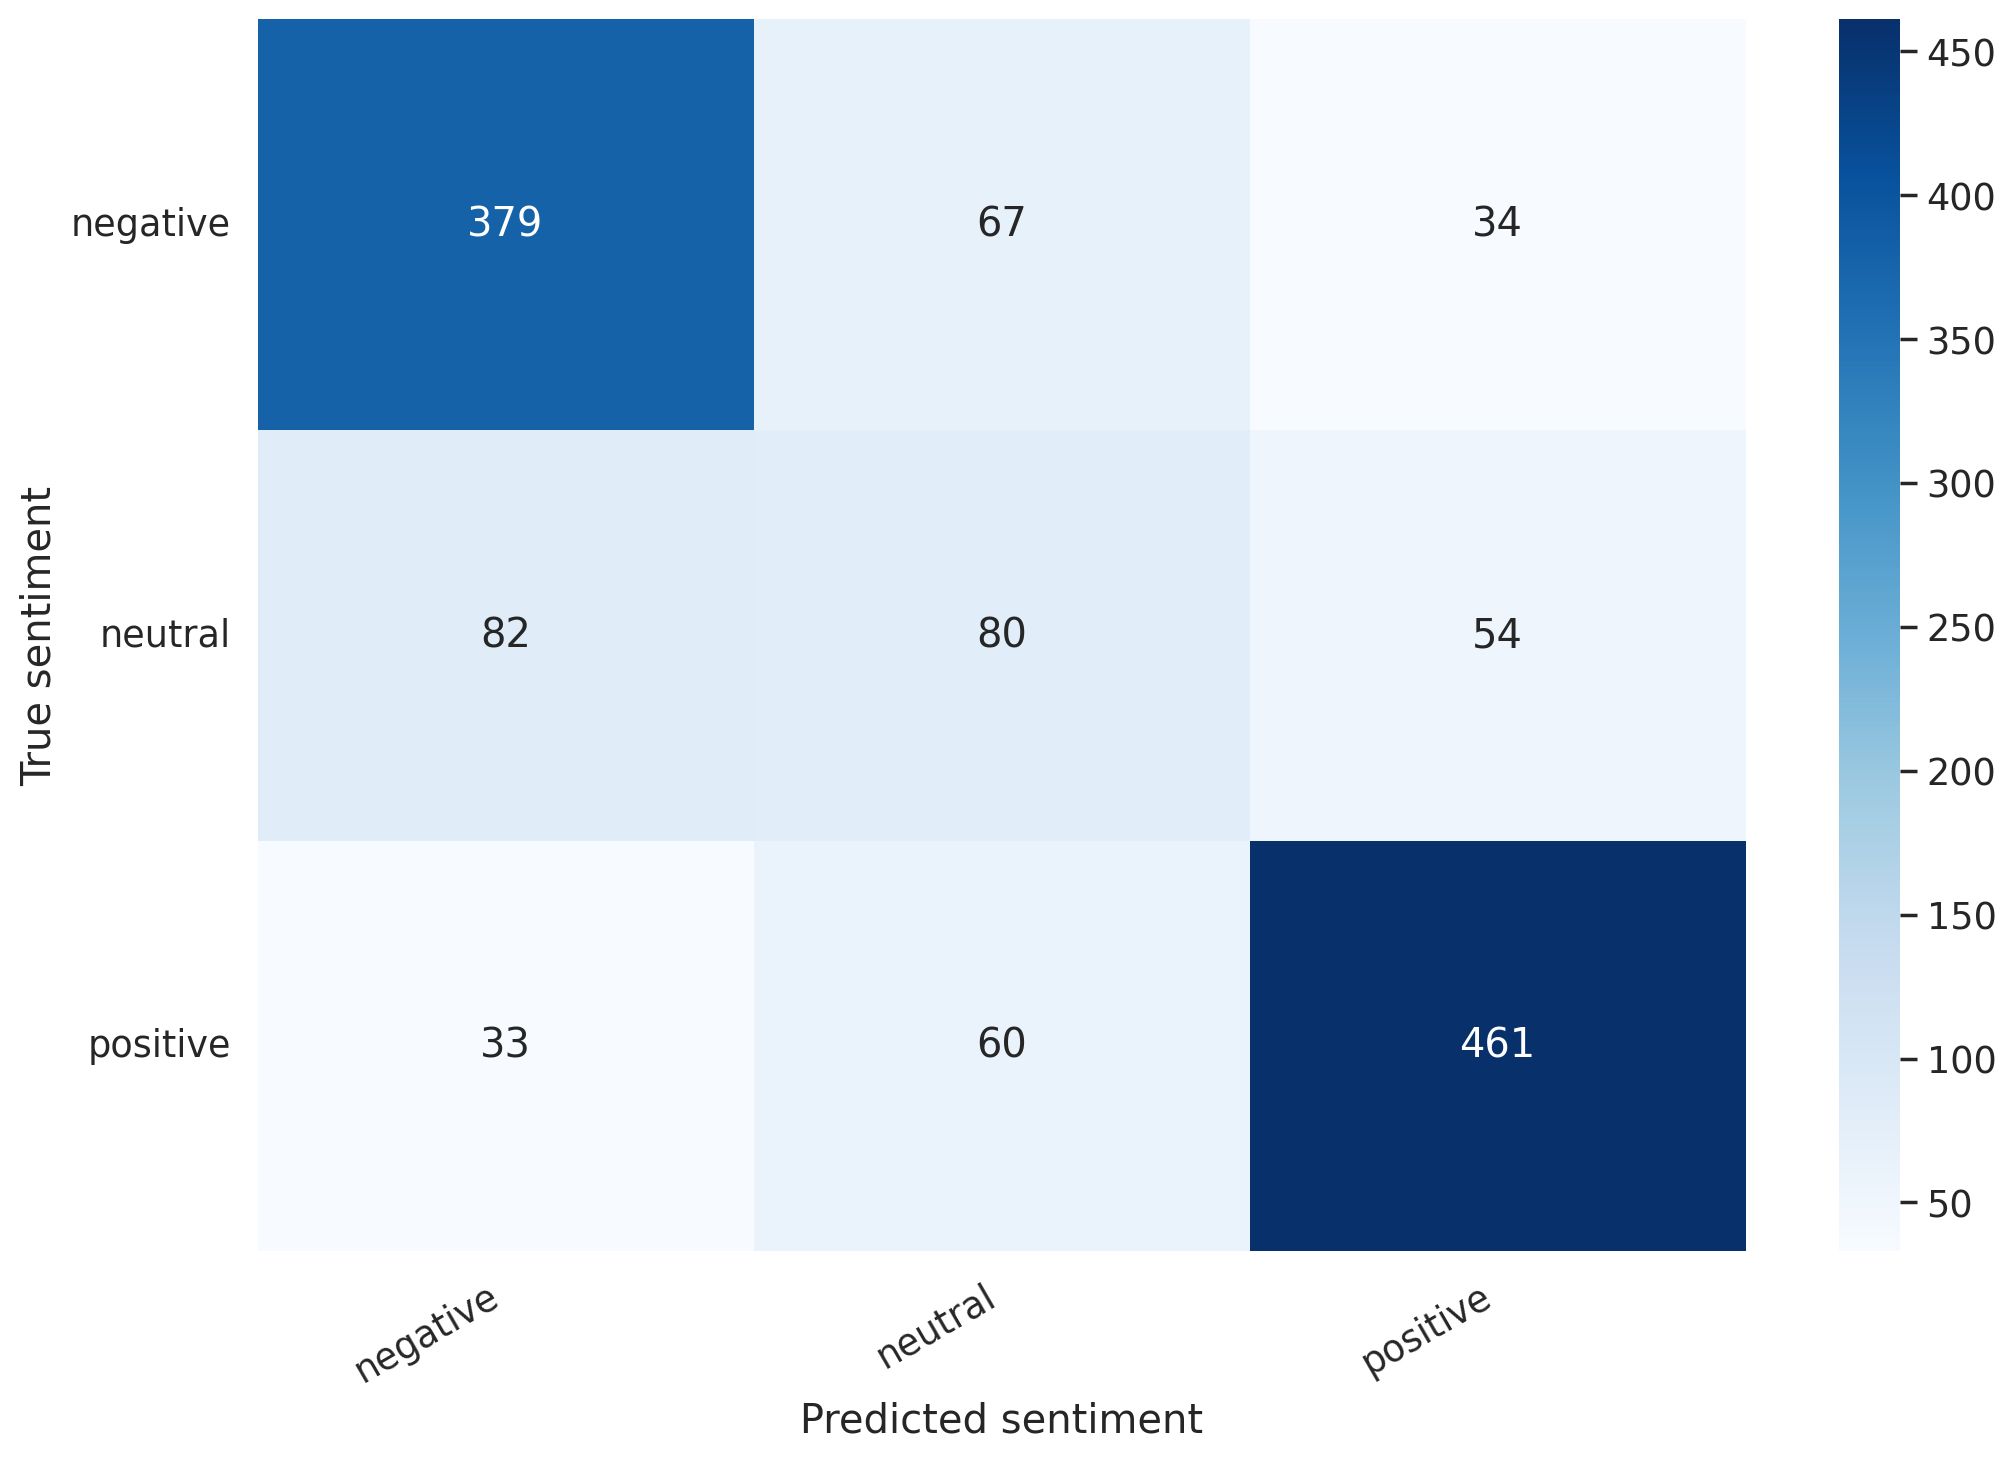

In [29]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)


In [30]:
review_text = "I love completing my todos! Best app ever!!!"
encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : positive


In [34]:
# save the model
!dir
torch.save(model.state_dict(), "./saved_model/google_review_finetuned_BERT_model.pt")

# save the tokenizer
tokenizer.save_pretrained("./saved_model/google_review_BERT_tokenizer.pt")

best_model_state.bin  google-play-store-reviews.zip  reviews.csv  sample_data  saved_model


('./saved_model/google_review_BERT_tokenizer.pt/tokenizer_config.json',
 './saved_model/google_review_BERT_tokenizer.pt/special_tokens_map.json',
 './saved_model/google_review_BERT_tokenizer.pt/vocab.txt',
 './saved_model/google_review_BERT_tokenizer.pt/added_tokens.json')

In [35]:
from google.colab import files
files.download("/content/saved_model/google_review_finetuned_BERT_model.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [39]:
!zip "/content/saved_model/google_review_BERT_tokenizer.zip" "/content/saved_model/google_review_BERT_tokenizer"

  adding: content/saved_model/google_review_BERT_tokenizer/ (stored 0%)


In [40]:
files.download("/content/saved_model/google_review_BERT_tokenizer.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# ABSA Practice I -- HuggingFace tutorial
code referencing: https://remicnrd.github.io/Aspect-based-sentiment-analysis/

data referencing: https://alt.qcri.org/semeval2014/task4/
data source: https://huggingface.co/datasets/jakartaresearch/semeval-absa

In [ ]:
!pip install datasets huggingface_hub transformers

In [ ]:
# listing and checking dataset
from datasets import list_datasets, load_dataset
from pprint import pprint

datasets = list_datasets()
SemEval_ABSA_dataset = list_datasets(with_details=True)[datasets.index("jakartaresearch/semeval-absa")]

pprint(SemEval_ABSA_dataset.__dict__)

<ipython-input-4-72941713108c>:5: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  datasets = list_datasets()
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


{'_id': '62f889a704de855c35e65ffb',
 'author': 'jakartaresearch',
 'cardData': {'annotations_creators': ['found'], 'language_creators': ['found'], 'language': ['en'], 'license': ['cc-by-4.0'], 'multilinguality': ['monolingual'], 'size_categories': ['1K<n<10K'], 'source_datasets': ['original'], 'task_categories': ['text-classification'], 'task_ids': ['sentiment-classification'], 'paperswithcode_id': None, 'pretty_name': 'SemEval 2015: Aspect-based Sentiement Analysis', 'config_names': None, 'train_eval_index': None, 'tags': ['aspect-based-sentiment-analysis', 'semeval', 'semeval2015']},
 'card_data': {'annotations_creators': ['found'], 'language_creators': ['found'], 'language': ['en'], 'license': ['cc-by-4.0'], 'multilinguality': ['monolingual'], 'size_categories': ['1K<n<10K'], 'source_datasets': ['original'], 'task_categories': ['text-classification'], 'task_ids': ['sentiment-classification'], 'paperswithcode_id': None, 'pretty_name': 'SemEval 2015: Aspect-based Sentiement Analysis',

In [ ]:
# downloading dataset -- pick between laptop or restaurant
dataset = load_dataset('jakartaresearch/semeval-absa', "restaurant")

Generating train split:   0%|          | 0/3044 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/800 [00:00<?, ? examples/s]

In [ ]:
pprint(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'aspects', 'category'],
        num_rows: 3044
    })
    validation: Dataset({
        features: ['id', 'text', 'aspects', 'category'],
        num_rows: 800
    })
})


In [ ]:
# get specific items
print(f"👉 Dataset len(dataset): {len(dataset)}")
print("\n👉 First item 'dataset[0]':")
pprint(dataset['train'][0])
print("/n")
# Or get slices with several examples:
print("\n👉Slice of the two items 'dataset[10:12]':")
pprint(dataset['train'][10:12])

👉 Dataset len(dataset): 2

👉 First item 'dataset[0]':
{'aspects': {'from': [8],
             'polarity': ['negative'],
             'term': ['staff'],
             'to': [13]},
 'category': {'category': ['service'], 'polarity': ['negative']},
 'id': '3121',
 'text': 'But the staff was so horrible to us.'}
/n

👉Slice of the two items 'dataset[10:12]':
{'aspects': [{'from': [71],
              'polarity': ['neutral'],
              'term': ['songs'],
              'to': [76]},
             {'from': [41, 18, 126, 73, 57, 170, 86],
              'polarity': ['negative',
                           'negative',
                           'negative',
                           'neutral',
                           'negative',
                           'neutral',
                           'neutral'],
              'term': ['toast',
                       'mayonnaise',
                       'bacon',
                       'cheese',
                       'ingredients',
                       

In [ ]:
# Datasets also have shapes informations
print("The number of rows", dataset.num_rows, "also available as len(dataset)", len(dataset))
print("The number of columns", dataset.num_columns)
print("The shape (rows, columns)", dataset.shape)

The number of rows {'train': 3044, 'validation': 800} also available as len(dataset) 2
The number of columns {'train': 4, 'validation': 4}
The shape (rows, columns) {'train': (3044, 4), 'validation': (800, 4)}


In [ ]:
# using .map to apply a function to each subset
dataset.map(lambda example: print(len(example["text"]), end=","))

Map:   0%|          | 0/3044 [00:00<?, ? examples/s]

36,151,153,67,88,69,41,159,87,44,131,196,98,42,59,91,53,90,41,84,78,38,26,40,26,31,78,82,38,30,17,123,81,78,25,62,127,73,47,83,72,71,16,21,53,60,67,65,183,38,31,167,52,60,86,75,63,27,50,134,73,36,89,63,71,79,81,79,26,29,39,89,27,71,75,22,82,83,75,61,94,63,39,54,82,45,115,30,81,94,86,67,72,46,50,106,35,63,130,21,105,120,94,56,78,97,70,78,114,26,17,70,34,18,62,41,69,60,45,73,89,49,40,85,153,26,147,58,83,86,42,55,41,208,77,67,32,44,66,19,64,56,52,127,182,81,60,60,28,43,144,155,38,106,63,26,108,44,35,57,30,69,67,134,107,61,35,68,120,85,109,49,29,28,31,76,111,88,48,109,46,21,64,184,55,123,88,76,63,12,133,9,24,12,97,69,116,33,79,80,40,68,84,70,251,66,79,76,24,55,91,112,65,53,29,6,11,66,77,34,82,128,44,208,62,126,94,120,53,65,47,79,102,140,52,152,178,18,130,50,33,45,36,41,71,87,62,13,82,34,44,41,46,87,73,25,48,99,206,52,15,186,26,115,44,21,21,17,32,105,70,49,56,8,83,100,84,136,25,35,35,23,177,61,106,89,39,90,155,75,23,67,98,75,65,68,183,53,39,25,20,45,93,92,69,82,76,65,88,89,67,51,97,31,75,14

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

31,70,43,45,108,53,58,40,32,70,61,105,93,51,29,25,141,40,53,63,143,76,78,119,77,74,46,45,48,71,98,106,38,34,131,43,53,97,34,40,32,34,88,64,56,95,42,191,81,43,41,59,56,49,59,77,124,74,165,114,36,32,52,63,108,86,34,48,40,67,67,52,105,53,34,43,36,69,93,45,90,87,65,43,37,40,146,55,53,58,63,42,48,51,50,83,40,41,39,47,31,43,82,50,52,84,29,107,42,116,88,31,58,71,75,64,102,74,79,81,60,122,27,46,49,93,52,91,31,50,34,83,43,104,81,102,60,53,70,64,100,38,60,42,55,53,58,65,154,90,32,33,120,66,27,60,47,42,37,38,29,67,57,27,61,40,57,58,39,58,122,61,49,39,69,160,70,60,104,47,66,81,34,35,26,30,100,61,63,69,27,66,67,36,31,49,111,41,53,50,44,48,34,61,147,39,118,75,90,55,79,38,106,62,60,70,82,30,32,46,78,34,94,72,121,107,38,67,112,36,60,53,29,33,231,37,143,142,90,136,58,42,74,25,73,48,76,53,32,155,65,41,28,94,97,100,44,33,44,31,28,31,29,80,50,179,30,48,50,79,52,62,32,70,45,189,32,36,29,65,36,58,47,79,72,48,78,28,27,79,26,27,48,43,31,36,51,25,30,108,55,55,73,90,37,47,50,73,44,78,32,60,85,77,54,104,53,91,99

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'aspects', 'category'],
        num_rows: 3044
    })
    validation: Dataset({
        features: ['id', 'text', 'aspects', 'category'],
        num_rows: 800
    })
})

In [ ]:
# removing columns
# This will remove the 'title' column while doing the update (after having send it the the mapped function so you can use it in your function!)
# less_columns_dataset = dataset.map(lambda example: {'new_title': 'Wouhahh: ' + example['title']}, remove_columns=['title'])

less_columns_dataset = dataset.map(lambda example: {'new_title': 'Wouhaha: ' + example['id']})
print(less_columns_dataset.column_names)
print(less_columns_dataset.unique('new_title'))

cleaned_dataset = less_columns_dataset.map(remove_columns=['new_title'])
print(cleaned_dataset.column_names)

Map:   0%|          | 0/3044 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

{'train': ['id', 'text', 'aspects', 'category', 'new_title'], 'validation': ['id', 'text', 'aspects', 'category', 'new_title']}
{'train': ['Wouhaha: 3121', 'Wouhaha: 2777', 'Wouhaha: 1634', 'Wouhaha: 2534', 'Wouhaha: 583', 'Wouhaha: 2846', 'Wouhaha: 1571', 'Wouhaha: 1458', 'Wouhaha: 3161', 'Wouhaha: 2391', 'Wouhaha: 986', 'Wouhaha: 296', 'Wouhaha: 1793', 'Wouhaha: 2200', 'Wouhaha: 3195', 'Wouhaha: 3119', 'Wouhaha: 3359', 'Wouhaha: 70', 'Wouhaha: 1829', 'Wouhaha: 2935', 'Wouhaha: 1805', 'Wouhaha: 2559', 'Wouhaha: 716', 'Wouhaha: 2464', 'Wouhaha: 385', 'Wouhaha: 1350', 'Wouhaha: 3534', 'Wouhaha: 1407', 'Wouhaha: 565', 'Wouhaha: 387', 'Wouhaha: 1314', 'Wouhaha: 675', 'Wouhaha: 2227', 'Wouhaha: 3367', 'Wouhaha: 1210', 'Wouhaha: 2191', 'Wouhaha: 270', 'Wouhaha: 638', 'Wouhaha: 500', 'Wouhaha: 1108', 'Wouhaha: 3294', 'Wouhaha: 388', 'Wouhaha: 3070', 'Wouhaha: 3373', 'Wouhaha: 425', 'Wouhaha: 3192', 'Wouhaha: 1098', 'Wouhaha: 2173', 'Wouhaha: 391', 'Wouhaha: 263', 'Wouhaha: 2384', 'Wouhaha: 2

Map:   0%|          | 0/3044 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

{'train': ['id', 'text', 'aspects', 'category'], 'validation': ['id', 'text', 'aspects', 'category']}


In [ ]:
# .map can be applied on batches
from transformers import BertTokenizerFast, logging as transformers_logging

transformers_logging.set_verbosity_warning()

tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")
encoded_dataset = cleaned_dataset.map(lambda example: tokenizer(example['text']), batched=True)

print("encoded_dataset[train][0]")
pprint(encoded_dataset['train'][0], compact=True)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/3044 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

encoded_dataset[train][0]
{'aspects': {'from': [8],
             'polarity': ['negative'],
             'term': ['staff'],
             'to': [13]},
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'category': {'category': ['service'], 'polarity': ['negative']},
 'id': '3121',
 'input_ids': [101, 1252, 1103, 2546, 1108, 1177, 9210, 1106, 1366, 119, 102],
 'text': 'But the staff was so horrible to us.',
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


In [ ]:
# tokenization using map done in batches and new columns being created
pprint(encoded_dataset.column_names)

{'train': ['id',
           'text',
           'aspects',
           'category',
           'input_ids',
           'token_type_ids',
           'attention_mask'],
 'validation': ['id',
                'text',
                'aspects',
                'category',
                'input_ids',
                'token_type_ids',
                'attention_mask']}


# ABSA Practice II -- ABSA model

In [ ]:
# reduce verbose
# from datasets import logging
# logging.set_verbosity_info()

# imports for ABSA
import pandas as pd
import spacy

# going to start from "scratch"
pprint(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'aspects', 'category'],
        num_rows: 3044
    })
    validation: Dataset({
        features: ['id', 'text', 'aspects', 'category'],
        num_rows: 800
    })
})


In [ ]:
# getting aspect terms
# pd.DataFrame(dataset['train']['text'], dataset['train']['category'])
pprint(dataset['train']['category'][:5])

# extract categories and polarities from huggingface data
def extract_keys(data, categories, polarities):
  categories.append(data['category'])
  polarities.append(data['polarity'])

train_categories = []
train_polarities = []
test_categories = []
test_polarities = []
dataset['train'].map(lambda example: extract_keys(example['category'], train_categories, train_polarities))
dataset['validation'].map(lambda example: extract_keys(example['category'], test_categories, test_polarities))

print(len(dataset['train']['text']))
print(len(train_categories))
print(len(train_polarities))

# create dataframes
train_split = pd.DataFrame({"sentiment": train_polarities, "aspect_category": train_categories, "review": dataset['train']['text']})
test_split = pd.DataFrame({"sentiment": test_polarities, "aspect_category": test_categories, "review": dataset['validation']['text']})

train_split[:5]

[{'category': ['service'], 'polarity': ['negative']},
 {'category': ['food', 'anecdotes/miscellaneous'],
  'polarity': ['positive', 'negative']},
 {'category': ['food'], 'polarity': ['positive']},
 {'category': ['service'], 'polarity': ['positive']},
 {'category': ['anecdotes/miscellaneous'], 'polarity': ['positive']}]


Map:   0%|          | 0/3044 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

3044
3044
3044


,sentiment,aspect_category,review
0,[negative],[service],But the staff was so horrible to us.
1,"[positive, negative]","[food, anecdotes/miscellaneous]","To be completely fair, the only redeeming fact..."
2,[positive],[food],"The food is uniformly exceptional, with a very..."
3,[positive],[service],Where Gabriela personaly greets you and recomm...
4,[positive],[anecdotes/miscellaneous],"For those that go once and don't enjoy it, all..."


In [ ]:
# extract string from columns
train_split['sentiment'] = [', '.join(x) for x in train_split['sentiment']]
train_split['aspect_category'] = [', '.join(x) for x in train_split['aspect_category']]
test_split['sentiment'] = [', '.join(x) for x in test_split['sentiment']]
test_split['aspect_category'] = [', '.join(x) for x in test_split['aspect_category']]
train_split.head()

,sentiment,aspect_category,review
0,negative,service,But the staff was so horrible to us.
1,"positive, negative","food, anecdotes/miscellaneous","To be completely fair, the only redeeming fact..."
2,positive,food,"The food is uniformly exceptional, with a very..."
3,positive,service,Where Gabriela personaly greets you and recomm...
4,positive,anecdotes/miscellaneous,"For those that go once and don't enjoy it, all..."


In [ ]:
# import spacy.cli
# spacy.cli.download("en_core_web_lg")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
gpu = spacy.prefer_gpu()
nlp = spacy.load('en_core_web_lg')
train_split.review = train_split.review.str.lower()

aspect_terms = []
for review in nlp.pipe(train_split.review):
  chunks = [(chunk.root.text) for chunk in review.noun_chunks if chunk.root.pos_ == "NOUN"]
  aspect_terms.append(" ".join(chunks))
train_split["aspect_term"] = aspect_terms
train_split.head()

,sentiment,aspect_category,review,aspect_term
0,negative,service,but the staff was so horrible to us.,staff
1,"positive, negative","food, anecdotes/miscellaneous","to be completely fair, the only redeeming fact...",factor food deficiencies teodora
2,positive,food,"the food is uniformly exceptional, with a very...",food kitchen menu
3,positive,service,where gabriela personaly greets you and recomm...,
4,positive,anecdotes/miscellaneous,"for those that go once and don't enjoy it, all...",


In [ ]:
empty_records = train_split[train_split["aspect_term"] == ""].index
train_split = train_split.drop(empty_records)
train_split.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2714 entries, 0 to 3043
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sentiment        2714 non-null   object
 1   aspect_category  2714 non-null   object
 2   review           2714 non-null   object
 3   aspect_term      2714 non-null   object
dtypes: object(4)
memory usage: 106.0+ KB


In [ ]:
train_split.aspect_category.unique()

array(['service', 'food, anecdotes/miscellaneous', 'food',
       'food, service', 'ambience', 'anecdotes/miscellaneous',
       'ambience, food', 'service, ambience',
       'anecdotes/miscellaneous, service', 'food, service, ambience',
       'food, price', 'ambience, price', 'price', 'service, price',
       'price, food', 'food, ambience', 'food, ambience, price',
       'food, ambience, service', 'anecdotes/miscellaneous, ambience',
       'anecdotes/miscellaneous, price', 'anecdotes/miscellaneous, food',
       'service, food', 'food, service, ambience, price',
       'service, ambience, price', 'food, service, price',
       'ambience, price, food', 'ambience, service',
       'anecdotes/miscellaneous, ambience, price, food',
       'ambience, anecdotes/miscellaneous', 'food, price, service',
       'service, anecdotes/miscellaneous',
       'price, anecdotes/miscellaneous',
       'food, service, anecdotes/miscellaneous', 'service, price, food',
       'price, service', 'food, 

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"

class AspectCategoryModel(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(AspectCategoryModel, self).__init__()
    self.flatten = nn.Flatten()
    self.criterion = nn.CrossEntropyLoss()
    self.model_stack = nn.Sequential(
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, output_size),
        nn.Softmax(dim=1)
    )
    self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)

  def forward(self, x):
    y = self.model_stack(x)
    return y

  def train(self, batch, epoch=1000):
    for i in range(epoch):
      self.optimizer.zero_grad()
      X, y = batch
      y_pred = self.model_stack(X)
      loss = self.criterion(y_pred, y)
      loss.backward()
      self.optimizer.step()